# Imports

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
import re
from numpy import random
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense, Flatten, SimpleRNN, InputLayer, Conv1D, Bidirectional, GRU, LSTM, BatchNormalization,
                                     Dropout, Input, Embedding, TextVectorization)
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files

In [2]:
! wget https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py

--2023-09-24 21:50:30--  https://raw.githubusercontent.com/DriveMyScream/Python_libraries/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7752 (7.6K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-09-24 21:50:30 (79.0 MB/s) - ‘helper_functions.py’ saved [7752/7752]



In [3]:
from helper_functions import calculate_results, plot_loss_curves, make_confusion_matrix

# Data Downloading

In [4]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 /root/.kaggle/kaggle.json
! kaggle datasets download -d hijest/cleaned-data-for-the-chatbot-collected-from-movies
! unzip "/content/cleaned-data-for-the-chatbot-collected-from-movies.zip" -d "/content/dataset/"

 95% 291M/305M [00:02<00:00, 158MB/s]
100% 305M/305M [00:02<00:00, 149MB/s]
Archive:  /content/cleaned-data-for-the-chatbot-collected-from-movies.zip
  inflating: /content/dataset/dialogs_expanded.csv  
  inflating: /content/dataset/input3.csv  
  inflating: /content/dataset/model_att29iter_expanded.data-00000-of-00001  
  inflating: /content/dataset/model_att29iter_expanded.index  
  inflating: /content/dataset/target3.csv  


# Data Loading

In [5]:
df = pd.read_csv("/content/dataset/dialogs_expanded.csv", usecols=['question', 'answer'])
df.head(5)

,question,answer
0,"Well, I thought we'd start with pronunciation,...",Not the hacking and gagging and spitting part....
1,Not the hacking and gagging and spitting part....,Okay... then how 'bout we try out some French ...
2,You're asking me out. That's so cute. What's ...,Forget it.
3,"No, no, it's my fault -- we didn't have a prop...",Cameron.
4,"Gosh, if only we could find Kat a boyfriend...",Let me see what I can do.


In [6]:
df.isnull().sum()

question    0
answer      0
dtype: int64

In [7]:
df.duplicated().sum()

710

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 138699 entries, 0 to 139408
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   question  138699 non-null  object
 1   answer    138699 non-null  object
dtypes: object(2)
memory usage: 3.2+ MB


In [10]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('https?://\S+|www\.\S+', ' ', text) # Remove URL from string
    text = re.sub('<.*?>+', ' ', text) # Remove HTML Tags
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text) # Replace Punctuation with space
    text = re.sub('\n', ' ', text) # Replace NewLine with space
    text = re.sub(r'\w*\d\w*', ' ', text) # Remove alphanumeric
    text = text.replace('-', ' ')
    text = text.replace('’’', '').replace('’', '').replace('‘‘', '').replace('‘', '')
    text = ' '.join(text.split())  # Strip extra spaces
    return text

In [11]:
df['question'] = df['question'].apply(clean_text)
df['answer'] = df['answer'].apply(clean_text)

In [12]:
question_sentences = []
answer_sentences = []
for question, answer in zip(df['question'], df['answer']):
  question = str(question)
  answer = str(answer)
  question_length = len(question.split())
  answer_length = len(answer.split())
  if (question_length >= 5) and (answer_length >= 5):
   question_sentences.append(question)
   answer_sentences.append(answer)

In [13]:
df = pd.DataFrame(list(zip(question_sentences, answer_sentences)), columns =['question', 'answer'])
df.head(5)

,question,answer
0,well i thought we d start with pronunciation i...,not the hacking and gagging and spitting part ...
1,not the hacking and gagging and spitting part ...,okay then how bout we try out some french cuis...
2,gosh if only we could find kat a boyfriend,let me see what i can do
3,c esc ma tete this is my head,right see you re ready for the quiz
4,how is our little find the wench a date plan p...,well there s someone i think might be


In [14]:
df.describe(include='object')

,question,answer
count,70318,70318
unique,68830,68982
top,what are you talking about,what are you talking about
freq,78,89


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70318 entries, 0 to 70317
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   question  70318 non-null  object
 1   answer    70318 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [178]:
answer_sequence_len = [len(sentence.split()) for sentence in df['answer']]
avg_answer_sequence_len = np.mean(answer_sequence_len)
question_sequence_len = [len(sentence.split()) for sentence in df['question']]
avg_question_sequence_len = np.mean(question_sequence_len)

print("Avg Answer Sequence Length:", avg_answer_sequence_len)
print("Avg Question Sequence Length:", avg_question_sequence_len)

Avg Answer Sequence Length: 10.038980062004038
Avg Question Sequence Length: 9.918797462954009


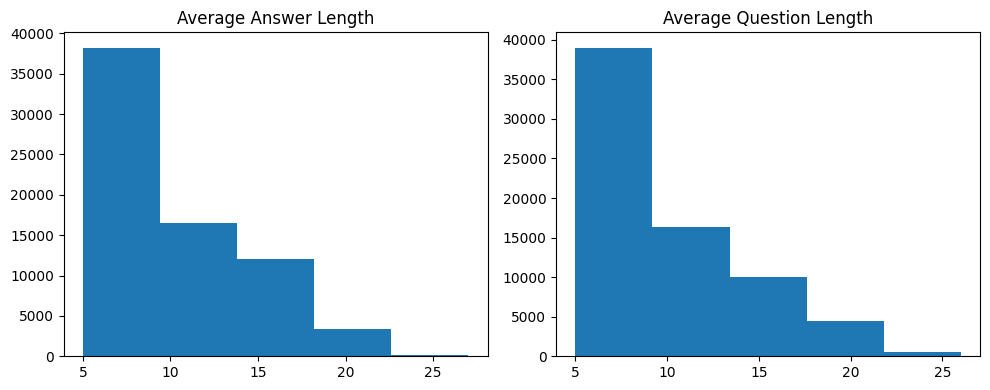

In [179]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.title("Average Answer Length")
plt.hist(answer_sequence_len, bins=5)

plt.subplot(1, 2, 2)
plt.title("Average Question Length")
plt.hist(question_sequence_len, bins=5)

plt.tight_layout()
plt.show()

In [180]:
output_answer_sequence_len = int(np.percentile(answer_sequence_len, 95))
output_question_sequence_len = int(np.percentile(question_sequence_len, 95))
print("Output Answer Sequence Length:", output_answer_sequence_len)
print("Output Question Sequence Length:", output_question_sequence_len)

Output Answer Sequence Length: 19
Output Question Sequence Length: 18


In [17]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [18]:
train_dataset = tf.data.Dataset.from_tensor_slices((train['question'], train['answer']))
test_dataset = tf.data.Dataset.from_tensor_slices((test['question'], test['answer']))

In [19]:
vocab_size = 20000
question_sequence_len = 18
answer_sequence_len = 18
embedding_dim = 128
batch_size = 64

In [20]:
question_vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                            max_tokens = vocab_size,
                                            output_mode = 'int',
                                            output_sequence_length = question_sequence_len)

In [21]:
sample_answer_vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                                max_tokens = vocab_size,
                                                output_mode = 'int',
                                                output_sequence_length = answer_sequence_len)

In [22]:
question_vectorize_layer.adapt(df['question'])

In [23]:
question_text_vocab = question_vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary: {len(question_text_vocab)}"),
print(f"Most common words in the vocabulary: {question_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {question_text_vocab[-5:]}")

Number of words in vocabulary: 20000
Most common words in the vocabulary: ['', '[UNK]', 'you', 'i', 'the']
Least common words in the vocabulary: ['dupe', 'duomo', 'dunwitty', 'dunlop', 'dunker']


In [24]:
question_vectorize_layer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None, None),
 'max_tokens': 20000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 18,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 20000}

In [25]:
sample_answer_vectorize_layer.adapt(df['answer'])

In [26]:
custom_tokens = ['starttoken', 'endtoken']
vocabulary = sample_answer_vectorize_layer.get_vocabulary()
vocabulary_with_custom_tokens = custom_tokens + [token for token in vocabulary if token not in ['', '[UNK]']]

In [27]:
vocab_size = 20000 + 2
answer_vectorize_layer = TextVectorization(standardize = 'lower_and_strip_punctuation',
                                          max_tokens = vocab_size,
                                          output_mode = 'int',
                                          output_sequence_length = answer_sequence_len)

In [28]:
answer_vectorize_layer.set_vocabulary(vocabulary_with_custom_tokens)

In [29]:
answer_vectorize_layer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'dtype': 'string',
 'max_tokens': 20002,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 18,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 20002}

In [30]:
answer_text_vocab = answer_vectorize_layer.get_vocabulary()
print(f"Number of words in vocabulary: {len(answer_text_vocab)}"),
print(f"Most common words in the vocabulary: {answer_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {answer_text_vocab[-5:]}")

Number of words in vocabulary: 20002
Most common words in the vocabulary: ['', '[UNK]', 'starttoken', 'endtoken', 'i']
Least common words in the vocabulary: ['denounce', 'denomination', 'denning', 'denise', 'denigrate']


In [31]:
def selector(inputs, outputs):
  return {'input_1': inputs, 'input_2': 'starttoken ' + outputs}, outputs + ' endtoken'

In [32]:
train_dataset = train_dataset.map(selector)
test_dataset = test_dataset.map(selector)

In [33]:
def vectorizer(inputs, outputs):
  return {'input_1': question_vectorize_layer(inputs['input_1']),
          'input_2': answer_vectorize_layer(inputs['input_2'])}, answer_vectorize_layer(outputs)

In [34]:
train_dataset = train_dataset.map(vectorizer)
test_dataset = test_dataset.map(vectorizer)

In [35]:
for inputs, outputs in train_dataset.take(1):
  question, answer = inputs['input_1'], inputs['input_2']
  print("Question:", question)
  print("Answer:", answer)
  print("Answer:", outputs)

Question: tf.Tensor([445  20  17 339 445  20   6  50 222  25  10 955  91   0   0   0   0   0], shape=(18,), dtype=int64)
Answer: tf.Tensor(
[   2    4   54   18   60   45   91 1381  106  127   46 1123  347    0
    0    0    0    0], shape=(18,), dtype=int64)
Answer: tf.Tensor(
[   4   54   18   60   45   91 1381  106  127   46 1123  347    3    0
    0    0    0    0], shape=(18,), dtype=int64)


In [36]:
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64, drop_remainder=True)
test_dataset = test_dataset.shuffle(buffer_size=1024).batch(64, drop_remainder=True)

In [37]:
train_dataset

<_BatchDataset element_spec=({'input_1': TensorSpec(shape=(64, None), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(64, None), dtype=tf.int64, name=None)}, TensorSpec(shape=(64, None), dtype=tf.int64, name=None))>

# Seq2Seq_Model

In [38]:
vocab_size = 20000
embedding_dim = 128
num_units = 256

In [39]:
input_layer = Input(shape=(18,), dtype="int64", name="input_1")
x = Embedding(vocab_size, embedding_dim)(input_layer)
encoded_input = Bidirectional(GRU(num_units))(x)

shifted_target = Input(shape=(18,), dtype="int64", name="input_2")
x = Embedding(vocab_size,embedding_dim)(shifted_target)
x = GRU(num_units*2, return_sequences=True)(x, initial_state = encoded_input)

x = Dropout(0.5)(x)
output_layer = Dense(vocab_size+2, activation="softmax")(x)
seq2seq_model = Model([input_layer, shifted_target], output_layer)
seq2seq_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 18)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 18)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 18, 128)              2560000   ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 18, 128)              2560000   ['input_2[0][0]']             
                                                                                              

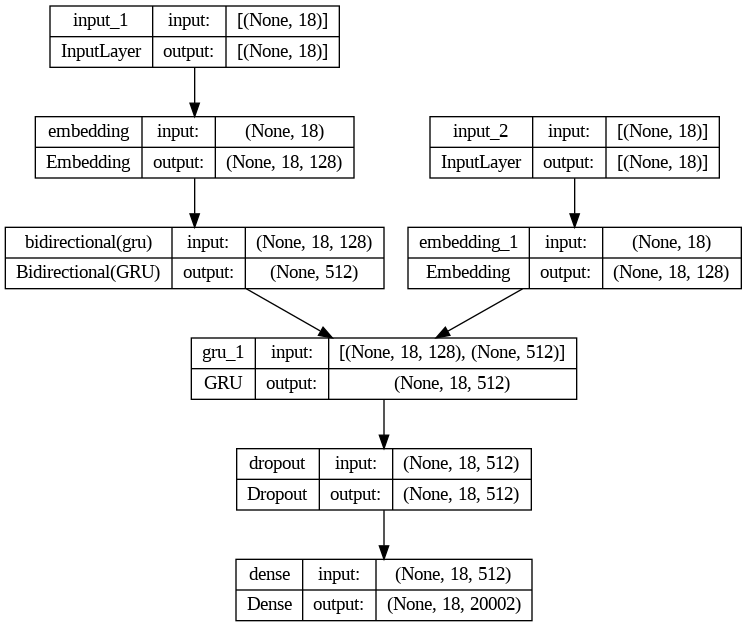

In [40]:
plot_model(seq2seq_model, show_shapes=True)

In [41]:
seq2seq_model.compile(loss = SparseCategoricalCrossentropy(from_logits=True),
                      optimizer = Adam(),
                      metrics=['accuracy'])

In [42]:
history = seq2seq_model.fit(train_dataset,
                            validation_data=test_dataset,
                            epochs=10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


878/878 [==============================] - 99s 99ms/step - loss: 3.5098 - accuracy: 0.4830 - val_loss: 3.0641 - val_accuracy: 0.5180
Epoch 2/10
878/878 [==============================] - 63s 72ms/step - loss: 2.9719 - accuracy: 0.5245 - val_loss: 2.9308 - val_accuracy: 0.5291
Epoch 3/10
878/878 [==============================] - 58s 66ms/step - loss: 2.8303 - accuracy: 0.5327 - val_loss: 2.8749 - val_accuracy: 0.5338
Epoch 4/10
878/878 [==============================] - 59s 66ms/step - loss: 2.7236 - accuracy: 0.5383 - val_loss: 2.8553 - val_accuracy: 0.5365
Epoch 5/10
878/878 [==============================] - 58s 65ms/step - loss: 2.6306 - accuracy: 0.5430 - val_loss: 2.8491 - val_accuracy: 0.5377
Epoch 6/10
878/878 [==============================] - 57s 64ms/step - loss: 2.5411 - accuracy: 0.5472 - val_loss: 2.8630 - val_accuracy: 0.5383
Epoch 7/10
878/878 [==============================] - 57s 65ms/step - loss: 2.4524 - accuracy: 0.5524 - val_loss: 2.8834 - val_accuracy: 0.5377
Epo

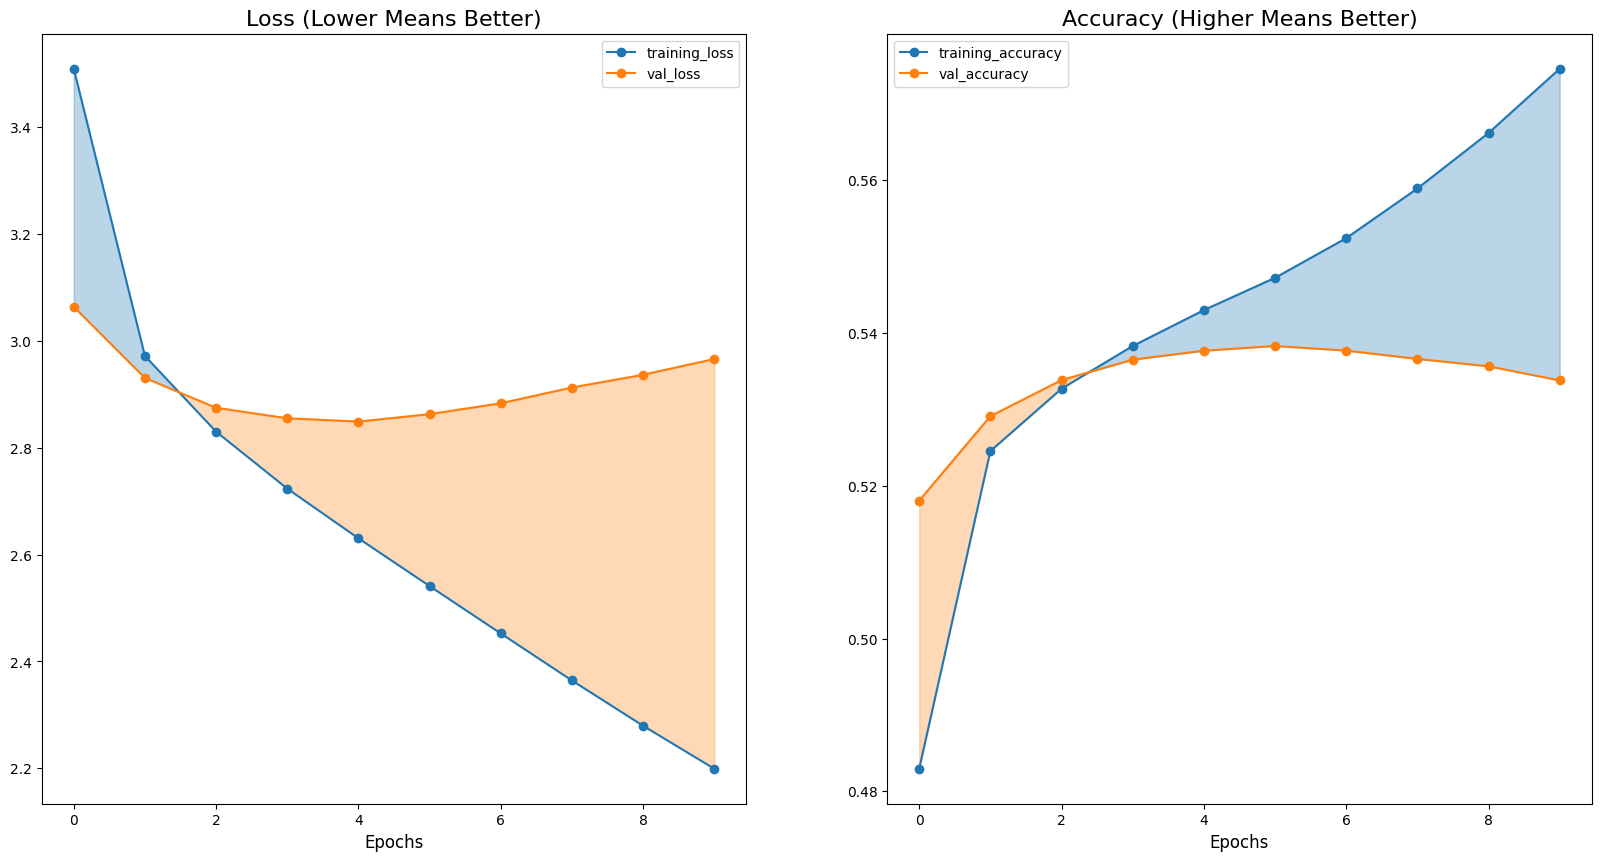

In [44]:
plot_loss_curves(history)

In [45]:
index_to_word = {x:y for x, y in zip(range(len(answer_vectorize_layer.get_vocabulary())),
                                     answer_vectorize_layer.get_vocabulary())}

In [46]:
train_data, test_data = train_test_split(test, test_size=0.005)

In [47]:
! pip install sacrebleu

In [51]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import sacrebleu
import numpy as np

NLTK_BLEU_SCORES = []
SAC_BLEU_SCORES = []
smoothing = SmoothingFunction()

for question, answer in zip(test_data['question'], test_data['answer']):
    tokenized_question_sentence = question_vectorize_layer([question])
    shifted_target = 'starttoken'

    for i in range(18):
        tokenized_shifted_target = answer_vectorize_layer([shifted_target])
        output = seq2seq_model.predict([tokenized_question_sentence, tokenized_shifted_target])
        answer_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
        current_word = index_to_word[answer_word_index]
        if current_word == 'endtoken':
            break
        shifted_target += ' ' + current_word
    predicted_sentence = shifted_target[11:]

    # Calculate BLEU scores
    nltk_bleu_score = sentence_bleu([answer.split()], predicted_sentence.split(), smoothing_function=smoothing.method1)
    sac_bleu_score = sacrebleu.corpus_bleu([predicted_sentence], [answer], force=True).score

    NLTK_BLEU_SCORES.append(nltk_bleu_score)
    SAC_BLEU_SCORES.append(sac_bleu_score)

# Calculate the mean BLEU scores
nltk_bleu_mean = np.mean(NLTK_BLEU_SCORES)
sac_bleu_mean = np.mean(SAC_BLEU_SCORES)

print("NLTK Mean BLEU Score:", nltk_bleu_mean)
print("SACREBLEU Mean BLEU Score:", sac_bleu_mean)

1/1 [==============================] - 0s 22ms/step
NLTK Mean BLEU Score: 0.017021981016911072
SACREBLEU Mean BLEU Score: 1.5788852548284058


# Bahdanau Attention

In [52]:
hidden_units = 256
embedding_dim = 256
vocab_size = 20000
sequence_len = 18

In [53]:
from tensorflow.keras import Model

In [54]:
@tf.keras.utils.register_keras_serializable()
class Encoder(Model):
  def __init__(self, vocab_size, embedding_dim, units):
    super(Encoder, self).__init__()
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    self.units = units

  def build(self, input_shape):
    self.embedding = Embedding(self.vocab_size, self.embedding_dim)
    self.lstm = LSTM(self.units, return_sequences=True)

  def call(self,x):
    x = self.embedding(x)
    output = self.lstm(x)
    return output

  def get_config(self):
    config = super(Encoder, self).get_config()
    config.update({
        'embedding_dim': self.embedding_dim,
        'vocab_size': self.vocab_size,
        'units': self.units,
    })
    return config

In [55]:
encoder = Encoder(vocab_size, embedding_dim, hidden_units)
encoder_output = encoder(tf.zeros([128, 8]))
print(encoder_output.shape)

(128, 8, 256)


In [56]:
from tensorflow.keras.layers import Layer

In [57]:
@tf.keras.utils.register_keras_serializable()
class BahdanauAttention(Layer):
  def __init__(self,units):
    super(BahdanauAttention, self).__init__()
    self.units = units

  def build(self,input_shape):
    self.w_1 = Dense(self.units)
    self.w_2 = Dense(self.units)
    self.w = Dense(1)

  def call(self, prev_dec_state, enc_states):
    scores = self.w(
        tf.nn.tanh(
        self.w_1(tf.expand_dims(prev_dec_state,-2)) +
        self.w_2(enc_states)))

    attention_weights = tf.nn.softmax(scores, axis=1)
    context_vector = attention_weights * enc_states
    context_vector = tf.reduce_sum(context_vector, axis=1)
    return context_vector, attention_weights

  def get_config(self):
    config = super(BahdanauAttention, self).get_config()
    config.update({
        'units': self.units,
    })
    return config

In [58]:
bahdanau_attention = BahdanauAttention(256)
context_vector, attention_weights = bahdanau_attention(tf.zeros([128,32]), tf.zeros([128,8,32]))
print(context_vector.shape)
print(attention_weights.shape)

(128, 32)
(128, 8, 1)


In [59]:
@tf.keras.utils.register_keras_serializable()
class Decoder(Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, sequence_length):
    super(Decoder,self).__init__()
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    self.dec_units = dec_units
    self.sequence_length = sequence_length

  def build(self,input_shape):
    self.dense = Dense(self.vocab_size, activation="softmax")
    self.gru = GRU(self.dec_units, return_sequences=True, return_state=True)
    self.attention = BahdanauAttention(self.dec_units)
    self.embedding = Embedding(self.vocab_size, self.embedding_dim)

  def call(self, x, hidden, shifted_target):
    outputs = []
    context_vectors = []
    attention_weightss = []
    shifted_target = self.embedding(shifted_target)

    for t in range(0, self.sequence_length):
      context_vector, attention_weights = self.attention(hidden, x)
      dec_input = context_vector+shifted_target[:,t]
      output,hidden = self.gru(tf.expand_dims(dec_input, 1))
      outputs.append(output[:,0])

    outputs = tf.convert_to_tensor(outputs)
    outputs = tf.transpose(outputs, perm=[1,0,2])

    outputs = self.dense(outputs)
    return outputs, attention_weights

  def get_config(self):
    config = super(Decoder, self).get_config()
    config.update({
        'embedding_dim': self.embedding_dim,
        'vocab_size': self.vocab_size,
        'units': self.dec_units,
        'sequence_length': self.sequence_length
    })
    return config

In [60]:
decoder = Decoder(vocab_size, embedding_dim, hidden_units, sequence_len)
outputs, attention_weights = decoder(encoder_output, tf.zeros([128, hidden_units]),tf.zeros([128,64]))
print(outputs.shape)
print(attention_weights.shape)

(128, 18, 20000)
(128, 8, 1)


In [61]:
input = Input(shape=(sequence_len,), dtype="int64", name="input_1")
encoder = Encoder(vocab_size,embedding_dim,hidden_units)
encoder_output = encoder(input)

shifted_target = Input(shape=(sequence_len,), dtype="int64", name="input_2")
decoder = Decoder(vocab_size+2,embedding_dim,hidden_units,sequence_len)
decoder_output,attention_weightss = decoder(encoder_output,tf.zeros([1,hidden_units]),shifted_target)

bahdanau = Model([input, shifted_target], decoder_output)
bahdanau.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 18)]                 0         []                            
                                                                                                  
 encoder_1 (Encoder)         (None, 18, 256)              5645312   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 18)]                 0         []                            
                                                                                                  
 decoder_1 (Decoder)         ((None, 18, 20002),          1078761   ['encoder_1[0][0]',           
                              (None, 18, 1))              9          'input_2[0][0]']       

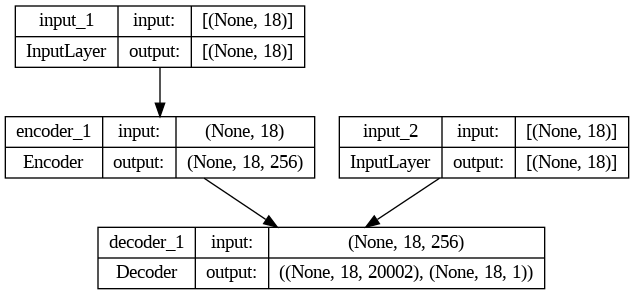

In [62]:
plot_model(bahdanau, show_shapes=True)

In [63]:
bahdanau.compile(loss = SparseCategoricalCrossentropy(from_logits=True),
                      optimizer = Adam(),
                      metrics=['accuracy'])

In [64]:
history = bahdanau.fit(train_dataset,
                      validation_data=test_dataset,
                      epochs=10)

Epoch 1/10
878/878 [==============================] - 161s 147ms/step - loss: 3.8331 - accuracy: 0.4443 - val_loss: 3.2295 - val_accuracy: 0.5006
Epoch 2/10
878/878 [==============================] - 95s 108ms/step - loss: 3.0520 - accuracy: 0.5154 - val_loss: 3.0339 - val_accuracy: 0.5188
Epoch 3/10
878/878 [==============================] - 85s 97ms/step - loss: 2.9030 - accuracy: 0.5251 - val_loss: 2.9837 - val_accuracy: 0.5219
Epoch 4/10
878/878 [==============================] - 87s 99ms/step - loss: 2.8140 - accuracy: 0.5305 - val_loss: 2.9606 - val_accuracy: 0.5247
Epoch 5/10
878/878 [==============================] - 84s 96ms/step - loss: 2.7399 - accuracy: 0.5355 - val_loss: 2.9583 - val_accuracy: 0.5244
Epoch 6/10
878/878 [==============================] - 84s 95ms/step - loss: 2.6730 - accuracy: 0.5399 - val_loss: 2.9668 - val_accuracy: 0.5237
Epoch 7/10
878/878 [==============================] - 85s 96ms/step - loss: 2.6075 - accuracy: 0.5440 - val_loss: 2.9855 - val_accura

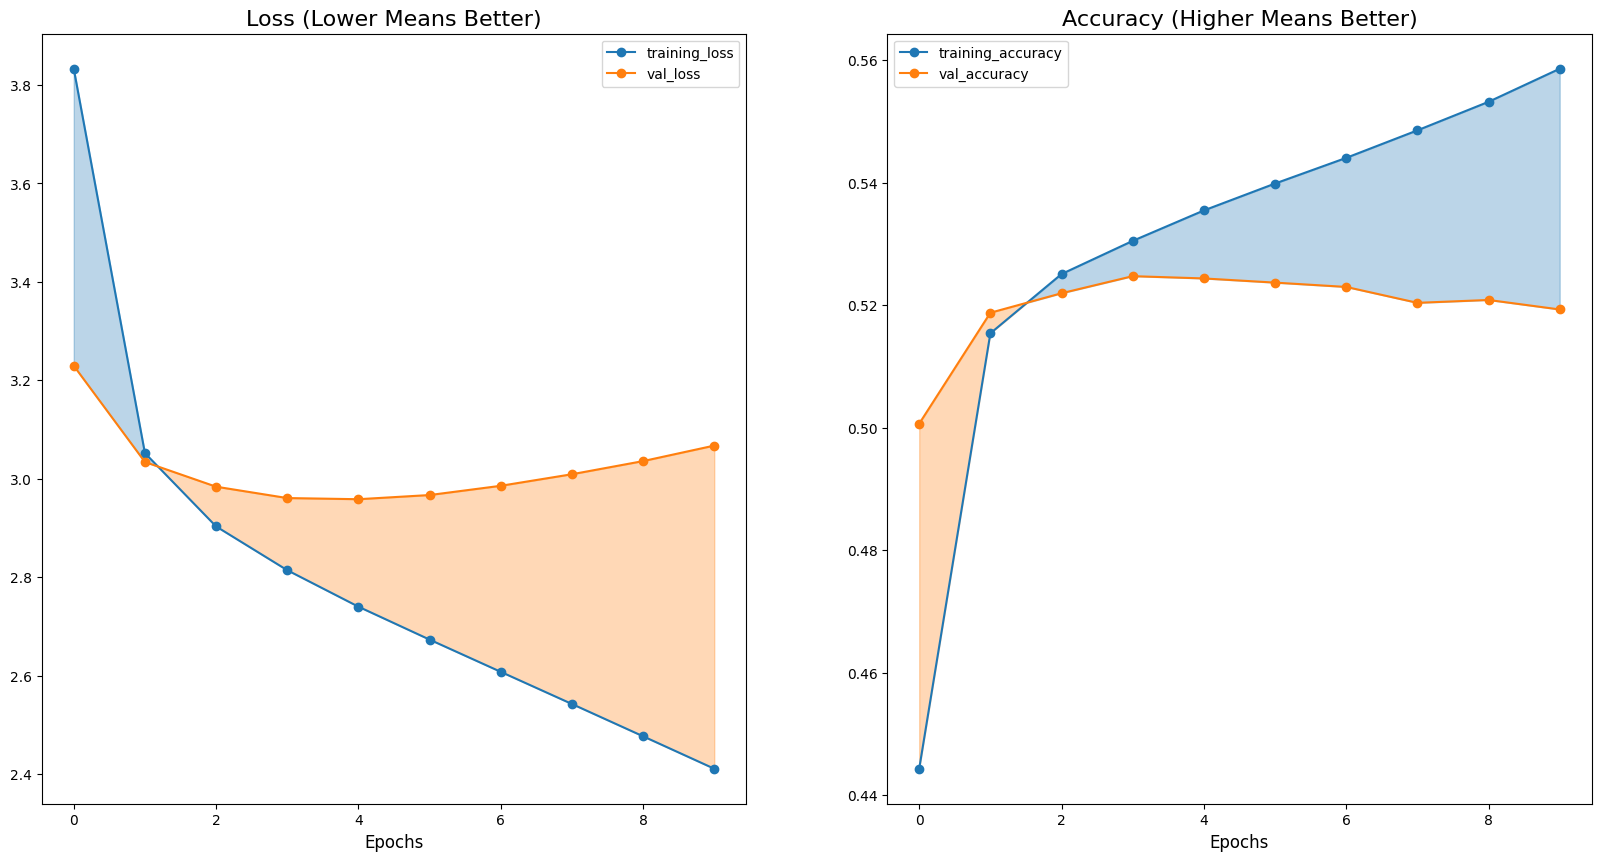

In [68]:
plot_loss_curves(history)

In [69]:
index_to_word = {x:y for x, y in zip(range(len(answer_vectorize_layer.get_vocabulary())),
                                     answer_vectorize_layer.get_vocabulary())}

In [70]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import sacrebleu
import numpy as np

NLTK_BLEU_SCORES = []
SAC_BLEU_SCORES = []
smoothing = SmoothingFunction()

for question, answer in zip(test_data['question'], test_data['answer']):
    tokenized_question_sentence = question_vectorize_layer([question])
    shifted_target = 'starttoken'

    for i in range(18):
        tokenized_shifted_target = answer_vectorize_layer([shifted_target])
        output = bahdanau.predict([tokenized_question_sentence, tokenized_shifted_target])
        answer_word_index = tf.argmax(output, axis=-1)[0][i].numpy()
        current_word = index_to_word[answer_word_index]
        if current_word == 'endtoken':
            break
        shifted_target += ' ' + current_word
    predicted_sentence = shifted_target[11:]

    # Calculate BLEU scores
    nltk_bleu_score = sentence_bleu([answer.split()], predicted_sentence.split(), smoothing_function=smoothing.method1)
    sac_bleu_score = sacrebleu.corpus_bleu([predicted_sentence], [answer], force=True).score

    NLTK_BLEU_SCORES.append(nltk_bleu_score)
    SAC_BLEU_SCORES.append(sac_bleu_score)

# Calculate the mean BLEU scores
nltk_bleu_mean = np.mean(NLTK_BLEU_SCORES)
sac_bleu_mean = np.mean(SAC_BLEU_SCORES)

print("NLTK Mean BLEU Score:", nltk_bleu_mean)
print("SACREBLEU Mean BLEU Score:", sac_bleu_mean)

1/1 [==============================] - 0s 42ms/step
NLTK Mean BLEU Score: 0.020326256414789138
SACREBLEU Mean BLEU Score: 1.2956300510686054


In [16]:
! pip install transformers
! pip install datasets
! pip install evaluate
! pip install sacrebleu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 28.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 621.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 3.3 MB/s eta 0:00:00


In [17]:
from datasets import Dataset
from transformers import (create_optimizer, DataCollatorForSeq2Seq, DataCollatorForLanguageModeling,
                          BlenderbotTokenizerFast, BlenderbotSmallTokenizerFast, TFBlenderbotForConditionalGeneration)

In [18]:
df = df.sample(10000)

In [19]:
dataset = Dataset.from_pandas(df)

In [20]:
dataset

Dataset({
    features: ['question', 'answer', '__index_level_0__'],
    num_rows: 10000
})

In [21]:
dataset[0]

{'question': 'it s funny sometimes i forget then it hits me and i can t stop crying',
 'answer': 'i try just to be happy i m still alive',
 '__index_level_0__': 61227}

In [22]:
model_id="facebook/blenderbot-400M-distill"
tokenizer = BlenderbotTokenizerFast.from_pretrained(model_id,truncation_side="left")

In [23]:
data_array = []
NUM_SAMPLES = 3

In [24]:
tokenizer.pad_token = tokenizer.eos_token

In [25]:
for i in range(NUM_SAMPLES,len(dataset)):
  question = ""
  bot_output = tokenizer.bos_token + dataset[i]["answer"] + tokenizer.eos_token
  for j in reversed(range(i-NUM_SAMPLES,i)):
    question = tokenizer.bos_token + dataset[j]["question"] + tokenizer.eos_token+question
    data_array.append([question, bot_output])

In [26]:
pd.DataFrame(data_array, columns=["question", "bot_output"]).to_csv('chats.csv')

In [27]:
df = pd.read_csv('/content/chats.csv')

In [28]:
df.head(5)

,Unnamed: 0,question,bot_output
0,0,<s>you re enshrined in his heart and memory un...,<s>sure didn t you ever hear of arlington ceme...
1,1,<s>yes i got the money</s><s>you re enshrined ...,<s>sure didn t you ever hear of arlington ceme...
2,2,<s>it s funny sometimes i forget then it hits ...,<s>sure didn t you ever hear of arlington ceme...
3,3,<s>did all these people die in wars</s>,<s>i ve got to get out of here diego</s>
4,4,<s>you re enshrined in his heart and memory un...,<s>i ve got to get out of here diego</s>


In [29]:
dataset = Dataset.from_pandas(df)

In [30]:
dataset

Dataset({
    features: ['Unnamed: 0', 'question', 'bot_output'],
    num_rows: 29991
})

In [31]:
def preprocess_function(example):
  return tokenizer(example['question'], text_target=example['bot_output'],
                   padding='max_length', max_length=64, truncation=True,)

In [32]:
tokenized_dataset = dataset.map(preprocess_function)

Map:   0%|          | 0/29991 [00:00<?, ? examples/s]

In [33]:
tokenized_dataset

Dataset({
    features: ['Unnamed: 0', 'question', 'bot_output', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 29991
})

In [34]:
model = TFBlenderbotForConditionalGeneration.from_pretrained(model_id)
model.summary()

All model checkpoint layers were used when initializing TFBlenderbotForConditionalGeneration.

Some layers of TFBlenderbotForConditionalGeneration were not initialized from the model checkpoint at facebook/blenderbot-400M-distill and are newly initialized: ['final_logits_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_blenderbot_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (TFBlenderbotMainLay  multiple                  364802560 
 er)                                                             
                                                                 
 final_logits_bias (BiasLay  multiple                  8008      
 er)                                                             
                                                                 
Total params: 364810568 (1.36 GB)
Trainable params: 364802560 (1.36 GB)
Non-trainable params: 8008 (31.28 KB)
_________________________________________________________________


In [35]:
def replacements(a):
  for i in [1,2]:
    condition = tf.equal(a, i)
    case_true = -100*tf.ones_like(a)
    case_false = a
    a=tf.where(condition, case_true, case_false)
  return a

In [36]:
def prepare_labels(inputs):
  return {'input_ids':inputs['input_ids'],
          'attention_mask':inputs['attention_mask'],
          'labels':replacements(inputs['labels'])}

In [37]:
tokenized_dataset = tokenized_dataset.map(prepare_labels)

Map:   0%|          | 0/29991 [00:00<?, ? examples/s]

In [38]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, return_tensors='tf')

In [39]:
dataset = tokenized_dataset.to_tf_dataset(batch_size=8,
    columns=["input_ids", "attention_mask", "labels"],
    shuffle=True,
    collate_fn=data_collator,
)

You're using a BlenderbotTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [40]:
for i in dataset.take(1):
  print(i)

{'input_ids': <tf.Tensor: shape=(8, 64), dtype=int64, numpy=
array([[   1,  359,  580, 1248,  265,  888, 6655, 2864,    2,    1,  815,
         403,  560, 1622,  338,  550,  271,  465,  296,    2,    1,  361,
         304,  507,  414, 2302,  422, 2502,  444, 1869,  891, 4726,  306,
         346, 5170,  404,  287, 1861,  448,  306, 3157,  419, 1073,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2],
       [   1, 2234, 3635, 3021,  607,  279,  324,  265, 1414,  607,  279,
        2292,    2,    1,  703,  287,  919,  494, 4666,  335, 3809, 1759,
           2,    1,  304,  325,  271, 3495, 2028, 2425,  903,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2,    2,    2,
           2,    2,    2,    2,    2,    2,    2,    2,    2],
       [   1,  607,  695,  398,  359,  325, 1151,  791, 3057,  747,    2,

In [43]:
num_epochs = 1
num_train_steps = len(dataset) * num_epochs
optimizer, schedule = create_optimizer(
  init_lr=6e-5,
  num_warmup_steps=1_000,
  num_train_steps=num_train_steps,
)
model.compile(optimizer=optimizer)

In [44]:
history = model.fit(dataset,
                   epochs = num_epochs)

3749/3749 [==============================] - 1607s 401ms/step - loss: 3.4332


KeyError: ignored

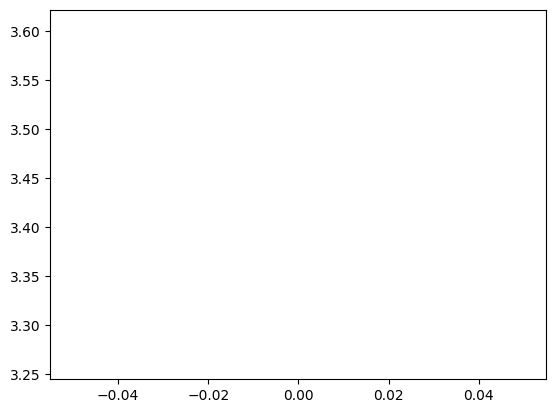

In [51]:
plt.plot(history.history['loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'])
plt.show()

In [ ]:
! pip install sacrebleu

In [ ]:
total_samples = len(dataset)

train_samples = int(0.9 * total_samples)
val_samples = total_samples - train_samples

tf_train_dataset = dataset.take(train_samples)
tf_val_dataset = dataset.skip(train_samples)

In [ ]:
import sacrebleu

all_preds = []
all_labels = []

for batch in tf_val_dataset.take(10):
    predictions = model.generate(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = batch["labels"].numpy()
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    all_preds.extend(decoded_preds)
    all_labels.extend(decoded_labels)

bleu_score = sacrebleu.corpus_bleu(all_preds, all_labels)
print("SACREBLEU Score:", bleu_score.score)

In [ ]:
MAX_LENGTH=1024
chat_input=""#"<s> A discussion between myself and Elon Musk who thinks his robots can get to mars</s>"

for step in range(10):
  my_text = input(">> Host:")
  new_user_input_ids = tokenizer.encode(tokenizer.bos_token+my_text+tokenizer.eos_token,return_tensors='tf')
  if step>0:
    chat_input = chat_input+tokenizer.bos_token+chat_history+tokenizer.eos_token+tokenizer.bos_token+my_text+tokenizer.eos_token
    bot_input_ids = tokenizer.encode(chat_input,return_tensors='tf')
  else:
    chat_input=tokenizer.bos_token+my_text+tokenizer.eos_token
    bot_input_ids = tokenizer.encode(chat_input,return_tensors='tf')

  chat_history_ids = model.generate(
      bot_input_ids,max_length=MAX_LENGTH,
      do_sample=True,
      temperature=2.0,top_k=50)

  chat_history=tokenizer.decode(chat_history_ids[0],skip_special_tokens=True,)

  print(">> Elon Musk: {}".format(tokenizer.decode(chat_history_ids[0], skip_special_tokens=True)))

# Saving and Loading Model

In [ ]:
from tensorflow.keras.saving import save_model, load_model

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [46]:
model.save("blenderbot")

In [ ]:
input_question = Input(shape=[1,], dtype='string')
output_layer = question_vectorize_layer(input_question)
question_vectorizer = Model(inputs=input_question, outputs=output_layer)

In [ ]:
question_vectorizer.save("question_vectorizer_model")
loaded_question_vectorizer = load_model("question_vectorizer_model")

In [ ]:
input_answer = Input(shape=[1,], dtype='string')
output_layer = answer_vectorize_layer(input_answer)
answer_vectorizer = Model(inputs=input_answer, outputs=output_layer)

In [ ]:
question_vectorizer.save("question_vectorizer_model")
loaded_question_vectorizer = load_model("question_vectorizer_model")

In [ ]:
answer_vectorizer.save("answer_vectorizer_model")
loaded_answer_vectorizer = load_model("answer_vectorizer_model")

In [ ]:
index_to_word = {x:y for x, y in zip(range(len(answer_vectorize_layer.get_vocabulary())),
                                                answer_vectorize_layer.get_vocabulary())}

In [ ]:
import json

filename = "index_to_word.json"
with open(filename, 'w') as file:
    json.dump(index_to_word, file)

In [ ]:
filename = "index_to_word.json"
with open(filename, 'r') as file:
    loaded_index_to_word = json.load(file)

In [ ]:
seq2seq_model.save("seq2seq_chatbot_model")

In [ ]:
loaded_seq2seq_model = load_model("seq2seq_chatbot_model")

In [ ]:
%cp -av /content/seq2seq_chatbot_model /content/drive/MyDrive/Different_News_Category_Classification

# Model at inference

In [ ]:
index_to_word={x:y for x, y in zip(range(len(answer_vectorize_layer.get_vocabulary())),
                                   answer_vectorize_layer.get_vocabulary())}

In [ ]:
def chatbot(question_sentence):
  tokenized_question_sentence = question_vectorize_layer([question_sentence])
  shifted_target = 'starttoken'

  for i in range(18):
    tokenized_shifted_target = answer_vectorize_layer([shifted_target])
    output = seq2seq_model.predict([tokenized_question_sentence, tokenized_shifted_target])
    word_to_index = tf.argmax(output, axis=-1)[0][i].numpy()
    current_word = index_to_word[word_to_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word

  return shifted_target[11:]

chatbot('What makes you think that is not true?')

# Hugging Face

In [47]:
! pip install huggingface_hub

In [48]:
from huggingface_hub import notebook_login
notebook_login()

In [49]:
model.push_to_hub("DriveMyScream/Blenderbot_ChatBot")
tokenizer.push_to_hub("DriveMyScream/Blenderbot_ChatBot")

tf_model.h5:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/DriveMyScream/Blenderbot_ChatBot/commit/89b11ca430c116b43100d9a07ec633811040197c', commit_message='Upload tokenizer', commit_description='', oid='89b11ca430c116b43100d9a07ec633811040197c', pr_url=None, pr_revision=None, pr_num=None)

In [50]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

pretrained_model = AutoModelForSeq2SeqLM.from_pretrained("DriveMyScream/Blenderbot_ChatBot", from_tf=True)
tokenizer = AutoTokenizer.from_pretrained("DriveMyScream/Blenderbot_ChatBot", from_tf=True)

All TF 2.0 model weights were used when initializing BlenderbotForConditionalGeneration.

Some weights of BlenderbotForConditionalGeneration were not initialized from the TF 2.0 model and are newly initialized: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from huggingface_hub.keras_mixin import push_to_hub_keras
push_to_hub_keras(model = model, repo_id = "DriveMyScream/Blenderbot_ChatBot")

In [ ]:
from huggingface_hub import from_pretrained_keras
loaded_model = from_pretrained_keras("DriveMyScream/Blenderbot_ChatBot")

In [ ]:
def chatbot(question_sentence):
  tokenized_question_sentence = question_vectorize_layer([question_sentence])
  shifted_target = 'starttoken'

  for i in range(18):
    tokenized_shifted_target = answer_vectorize_layer([shifted_target])
    output = loaded_model.predict([tokenized_question_sentence, tokenized_shifted_target])
    word_to_index = tf.argmax(output, axis=-1)[0][i].numpy()
    current_word = index_to_word[word_to_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word

  return shifted_target[11:]

In [ ]:
chatbot('What makes you think that is not true?')

# Tensorflow Lite

In [ ]:
import tensorflow as tf

# path = "/content/transformer_model"
# model = tf.keras.models.load_model(path)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter._experimental_lower_tensor_list_ops = False
tflite_model = converter.convert()

tflite_output_path = "Blenderbot_ChatBot.tflite"
with open(tflite_output_path, "wb") as f:
    f.write(tflite_model)

In [ ]:
model_path = "/content/chatbot_model.tflite"
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

question_sentence = "Before the problems acquire a serious dimension, remember that such problems occur because of exhaustion and lack of oxygen."
tokenized_question_sentence = question_vectorize_layer([question_sentence])
shifted_target = 'starttoken'
max_sequence_length = 18

for i in range(max_sequence_length):
    tokenized_shifted_target = answer_vectorize_layer([shifted_target])
    interpreter.set_tensor(input_details[0]['index'], tokenized_question_sentence)
    interpreter.set_tensor(input_details[1]['index'], tokenized_shifted_target)
    interpreter.invoke()
    output_data = interpreter.get_tensor(output_details[0]['index'])
    word_to_index = tf.argmax(output_data, axis=-1)[0][i].numpy()
    current_word = index_to_word[word_to_index]
    if current_word == 'endtoken':
        break
    shifted_target += ' ' + current_word

sentence = shifted_target[11:]
print(sentence)